In [12]:
from os.path import join as opj
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [13]:
data_root = '/om2/user/rogerjin/data/Ben'
data_path = opj(data_root, 'data_files_new.npz')
data = np.load(data_path, allow_pickle=True)
rna = data['rna_train']
atac = data['atac_train_small']

In [14]:
def zero_frac(arr):
    zero_count = np.count_nonzero(arr==0)
    return zero_count/arr.size

In [15]:
print('rna zero frac:', zero_frac(rna))
print('atac zero frac:', zero_frac(atac))

rna zero frac: 0.0
atac zero frac: 0.9740022531413609


In [16]:
list(data.keys())

['peak_selector',
 'atac_train_small',
 'atac_test_small',
 'rna_train',
 'rna_test',
 'rna_good_feats',
 'train_idx',
 'test_idx',
 'cell_type_train',
 'cell_type_test']

In [17]:
import torch
torch.cuda.is_available()

True

In [18]:
import pandas as pd
gene_list = pd.read_csv(f'{data_root}/gene_list.csv', header=None)

In [19]:
chosen_genes = gene_list[data['rna_good_feats']]

In [20]:
from os.path import join as opj
import numpy as np

cell_labels_train = data['cell_type_train']

In [21]:
cell_labels_train.shape

(6897,)

In [22]:
from GanoliModel import GanoliPCAGAN
model_cls = GanoliPCAGAN

Global seed set to 42


In [23]:
%load_ext autoreload
%autoreload 2

In [24]:
from sklearn.decomposition import PCA

train_rna = data['rna_train']
train_atac = data['atac_train_small']
pca_rna = PCA(n_components=20)
pca_atac = PCA(n_components=20)
pca_rna.fit_transform(train_rna)
pca_atac.fit_transform(train_atac)
rna_embedding = torch.Tensor(pca_rna.components_.T).to('cuda:0')
atac_embedding = torch.Tensor(pca_atac.components_.T).to('cuda:0')

In [27]:
model = 'logistic_embed_pca_lr=0.0002_beta1=0.5'
version = 0
checkpoint = 'step=92015-epoch=425-val_oracle_total=1.10.ckpt'

checkpoint_dir = f'/om2/user/rogerjin/GANOLI/ganoli/models/logs/{model}/default/version_{version}/checkpoints/'
checkpoint_path = f'{checkpoint_dir}/{checkpoint}'

In [28]:
ckpt_model = model_cls.load_from_checkpoint(checkpoint_path=checkpoint_path, rna_shape=7445, atac_shape=3808, rna_embedding=rna_embedding, atac_embedding=atac_embedding)

In [29]:
ckpt_model.to('cuda:0')

GanoliPCAGAN(
  (generator_rna2atac): GanoliLogisticGenerator(
    (linear): Linear(in_features=20, out_features=3808, bias=True)
    (sigmoid): Sigmoid()
  )
  (generator_atac2rna): GanoliLinearGenerator(
    (model): Linear(in_features=20, out_features=7445, bias=True)
  )
  (discriminator_rna): GanoliLinearDiscriminator(
    (model): Linear(in_features=20, out_features=1, bias=True)
  )
  (discriminator_atac): GanoliLinearDiscriminator(
    (model): Linear(in_features=20, out_features=1, bias=True)
  )
  (reconstruction_loss_fn): MSELoss()
  (identity_loss_fn): MSELoss()
  (generator_loss_fn): BCEWithLogitsLoss()
  (discriminator_loss_fn): BCEWithLogitsLoss()
)

In [30]:
atac_val = data['atac_test_small']

In [31]:
import torch
atac_val = torch.Tensor(atac_val).to('cuda:0')

In [32]:
atac_val_mini = atac_val[:10, :]

In [33]:
rna_val_pred = ckpt_model(atac_val,data_type='atac')

In [34]:
rna_val_pred.shape

torch.Size([2300, 7445])

In [35]:
rna_val_labels = data['cell_type_test']

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'Cell Type' as categorical


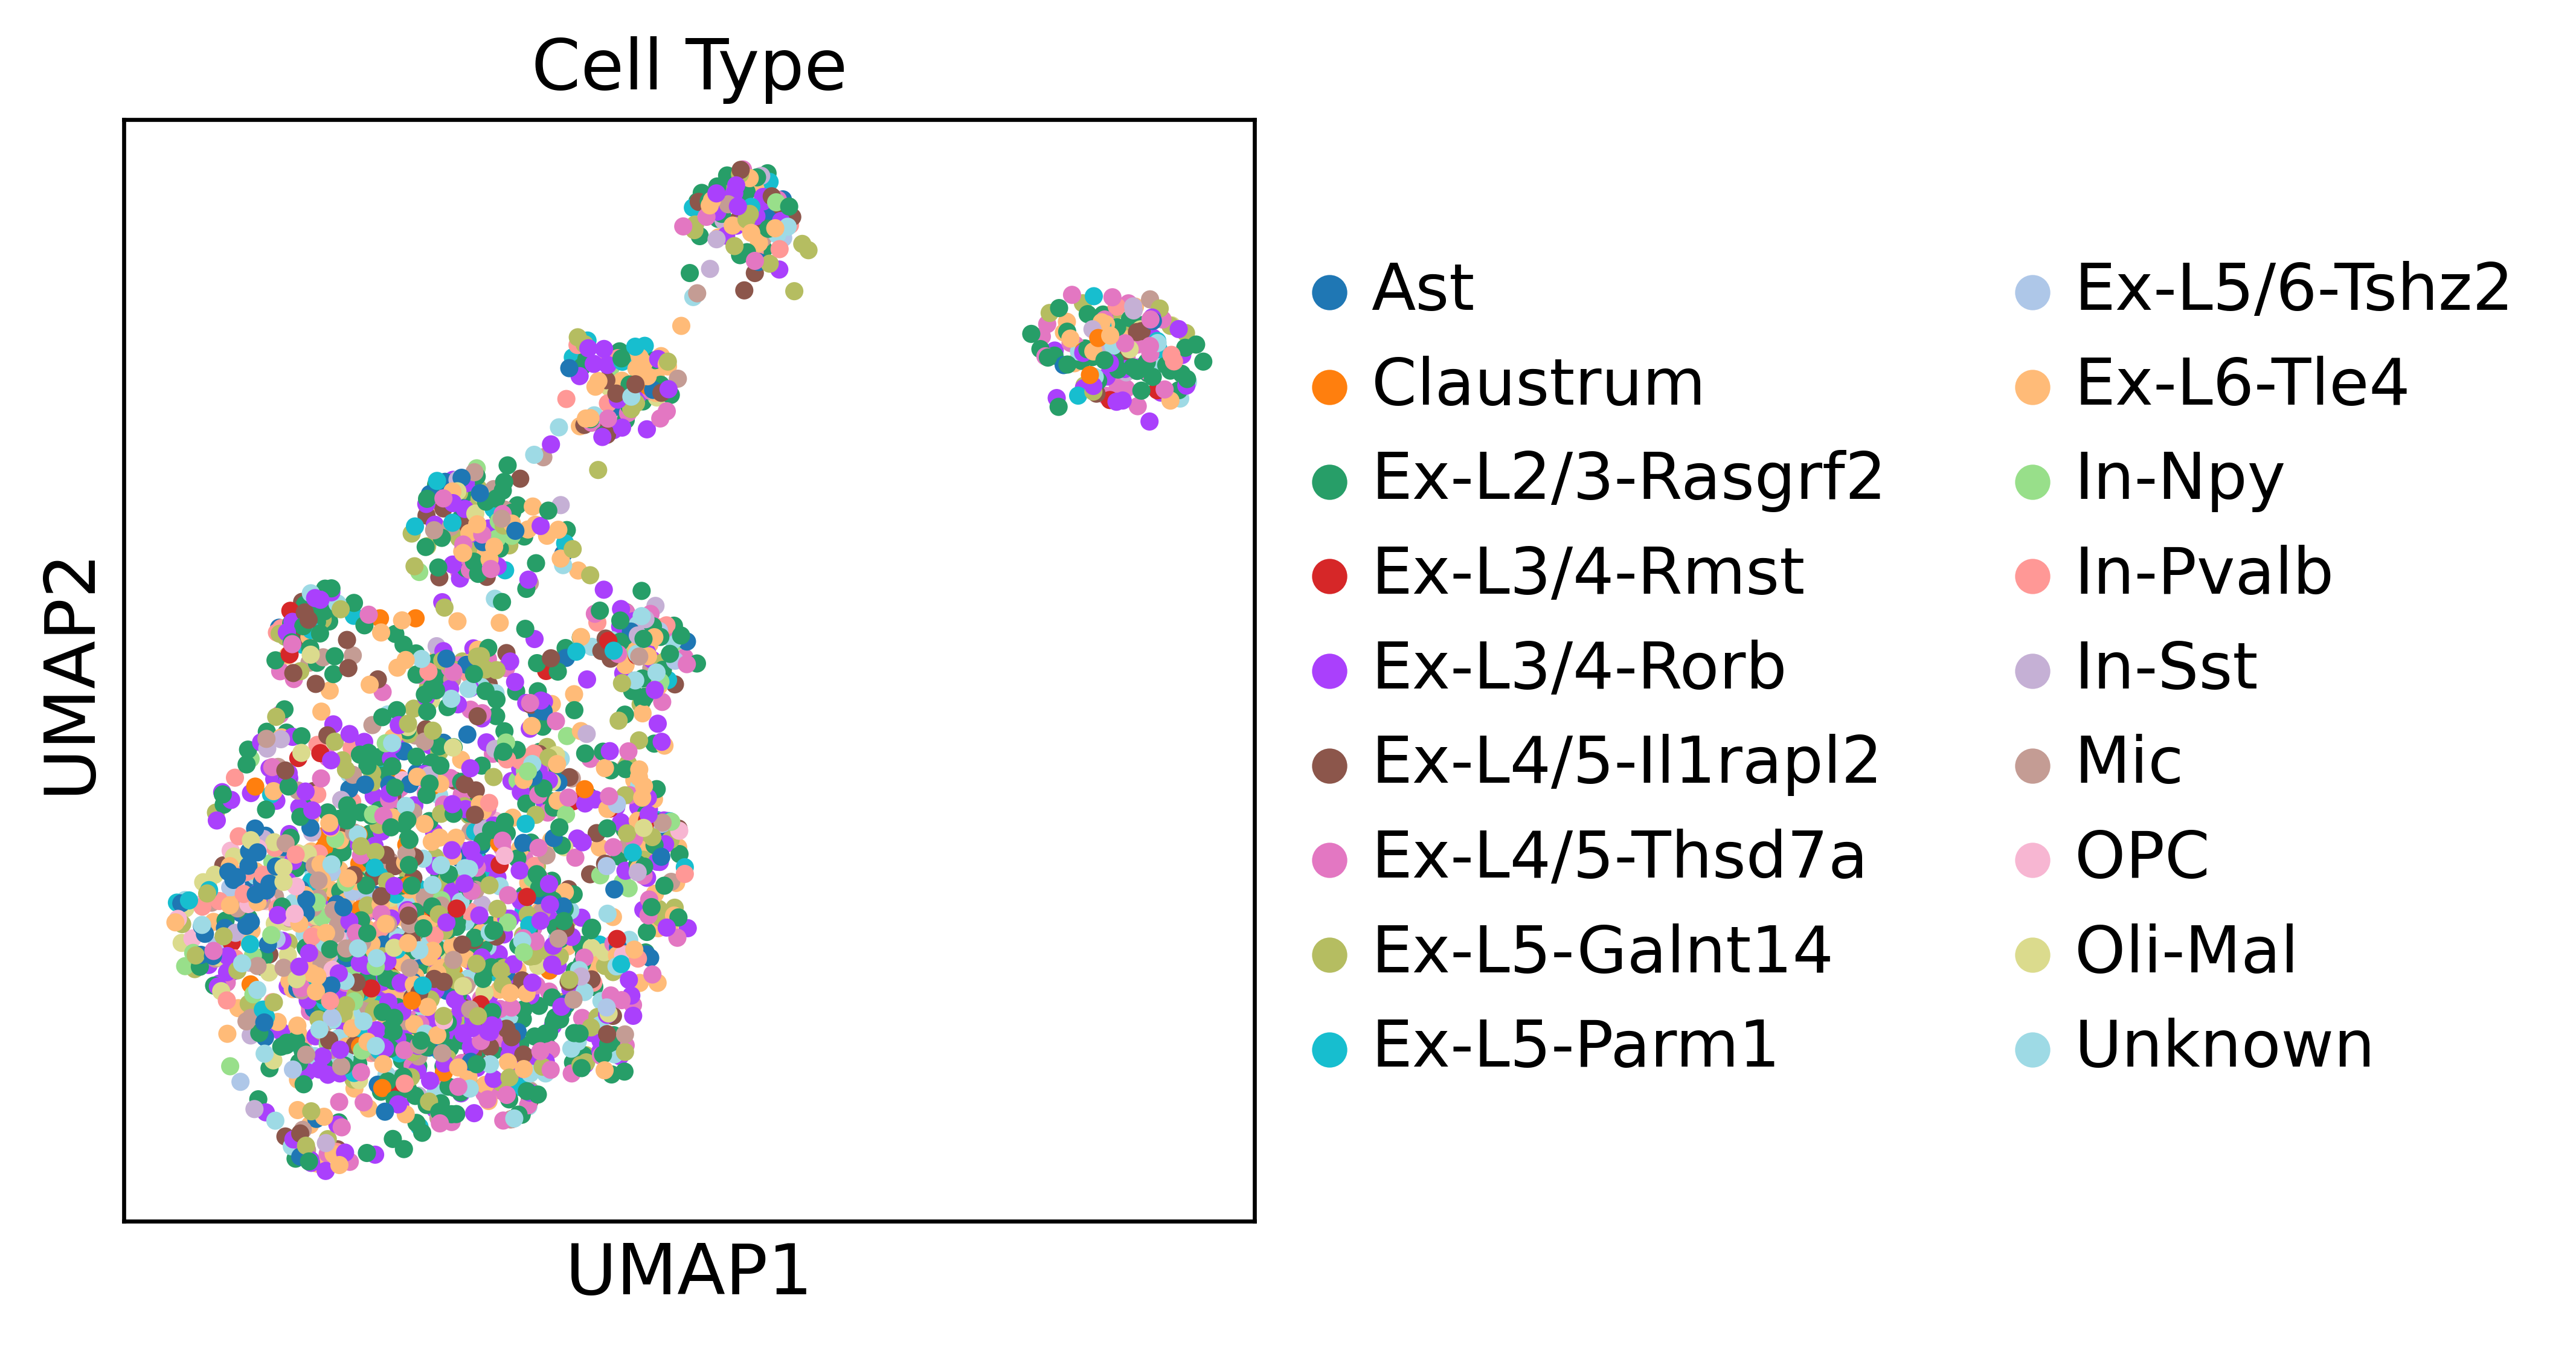

AnnData object with n_obs × n_vars = 2300 × 7445
    obs: 'Cell Type', 'leiden'
    uns: 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap', 'Cell Type_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [39]:
from ganoli_plot import plot_umap

plot_umap(rna_val_pred.detach().cpu().numpy(), rna_val_labels, label_name="Cell Type")

In [48]:
rna_val_pred.detach().cpu().numpy().shape

(2300, 7445)

In [49]:
rna_concat = np.vstack([data['rna_test'], rna_val_pred.detach().cpu().numpy()])

In [60]:
cell_label_concat = np.hstack([rna_val_labels, rna_val_labels])
cell_label_concat.shape

(4600,)

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'Cell Type' as categorical


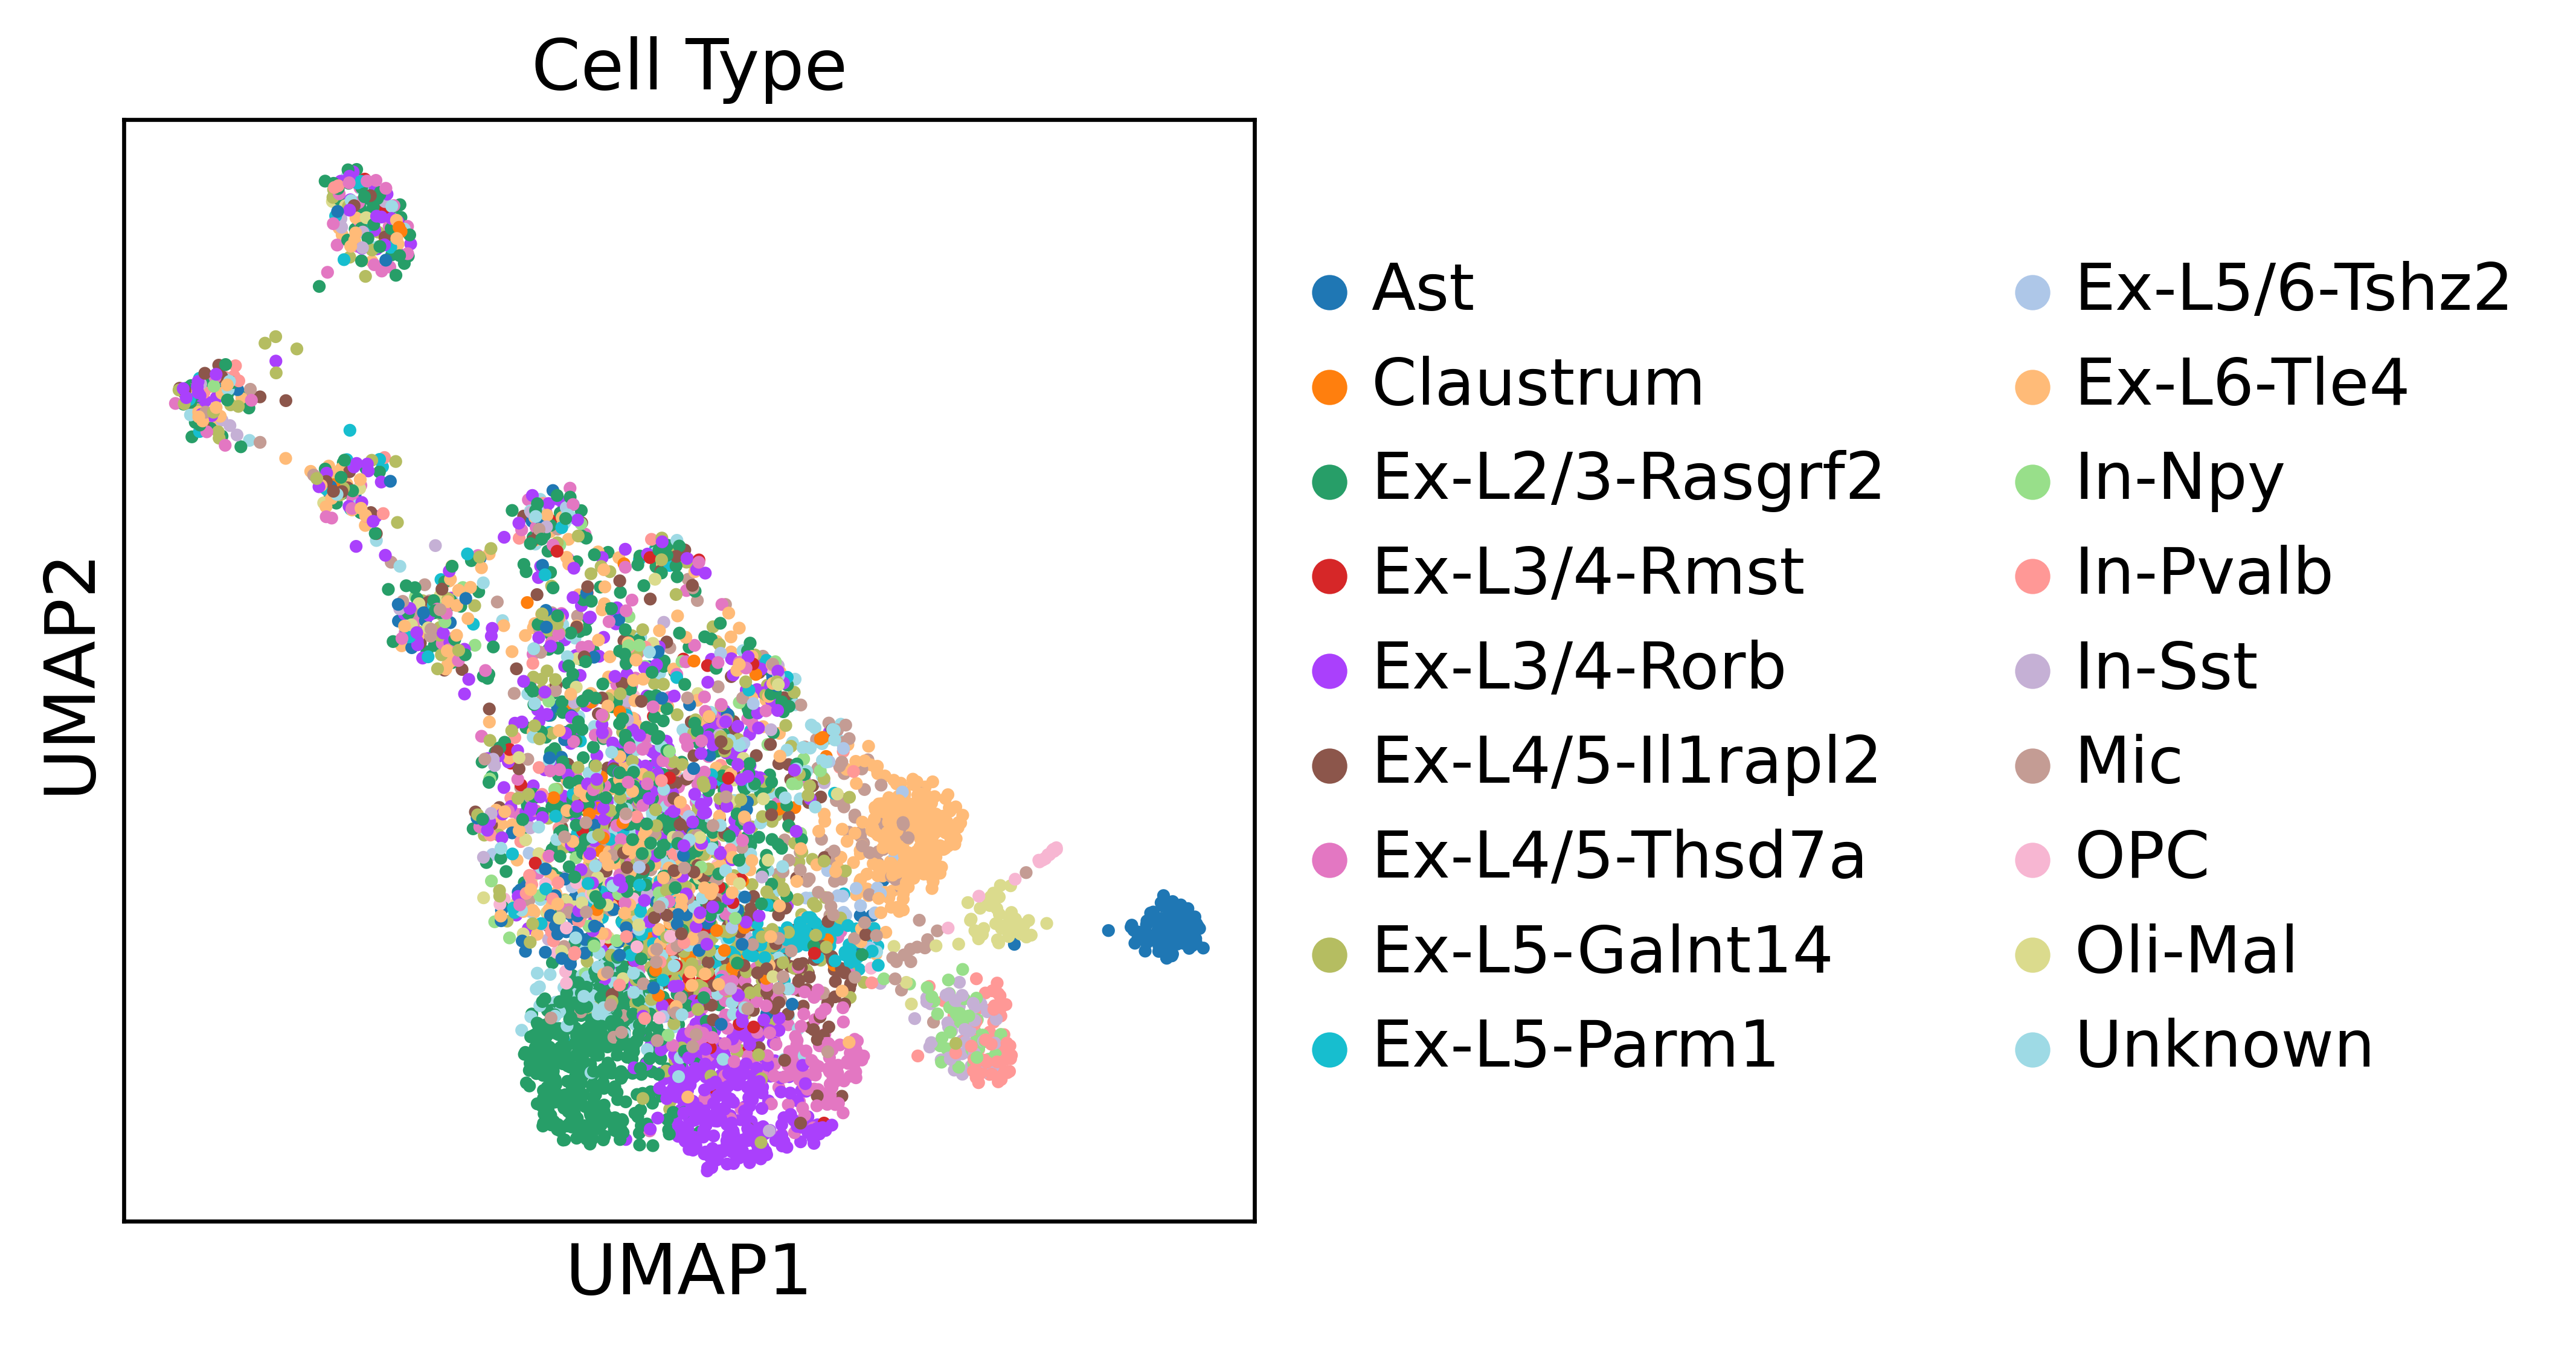

AnnData object with n_obs × n_vars = 4600 × 7445
    obs: 'Cell Type', 'leiden'
    uns: 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap', 'Cell Type_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [61]:
plot_umap(rna_concat, cell_label_concat, label_name="Cell Type")

In [67]:
source_labels = np.hstack([np.repeat('pred', 2300), np.repeat('true', 2300)])
source_labels.shape

(4600,)

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'RNA Source' as categorical


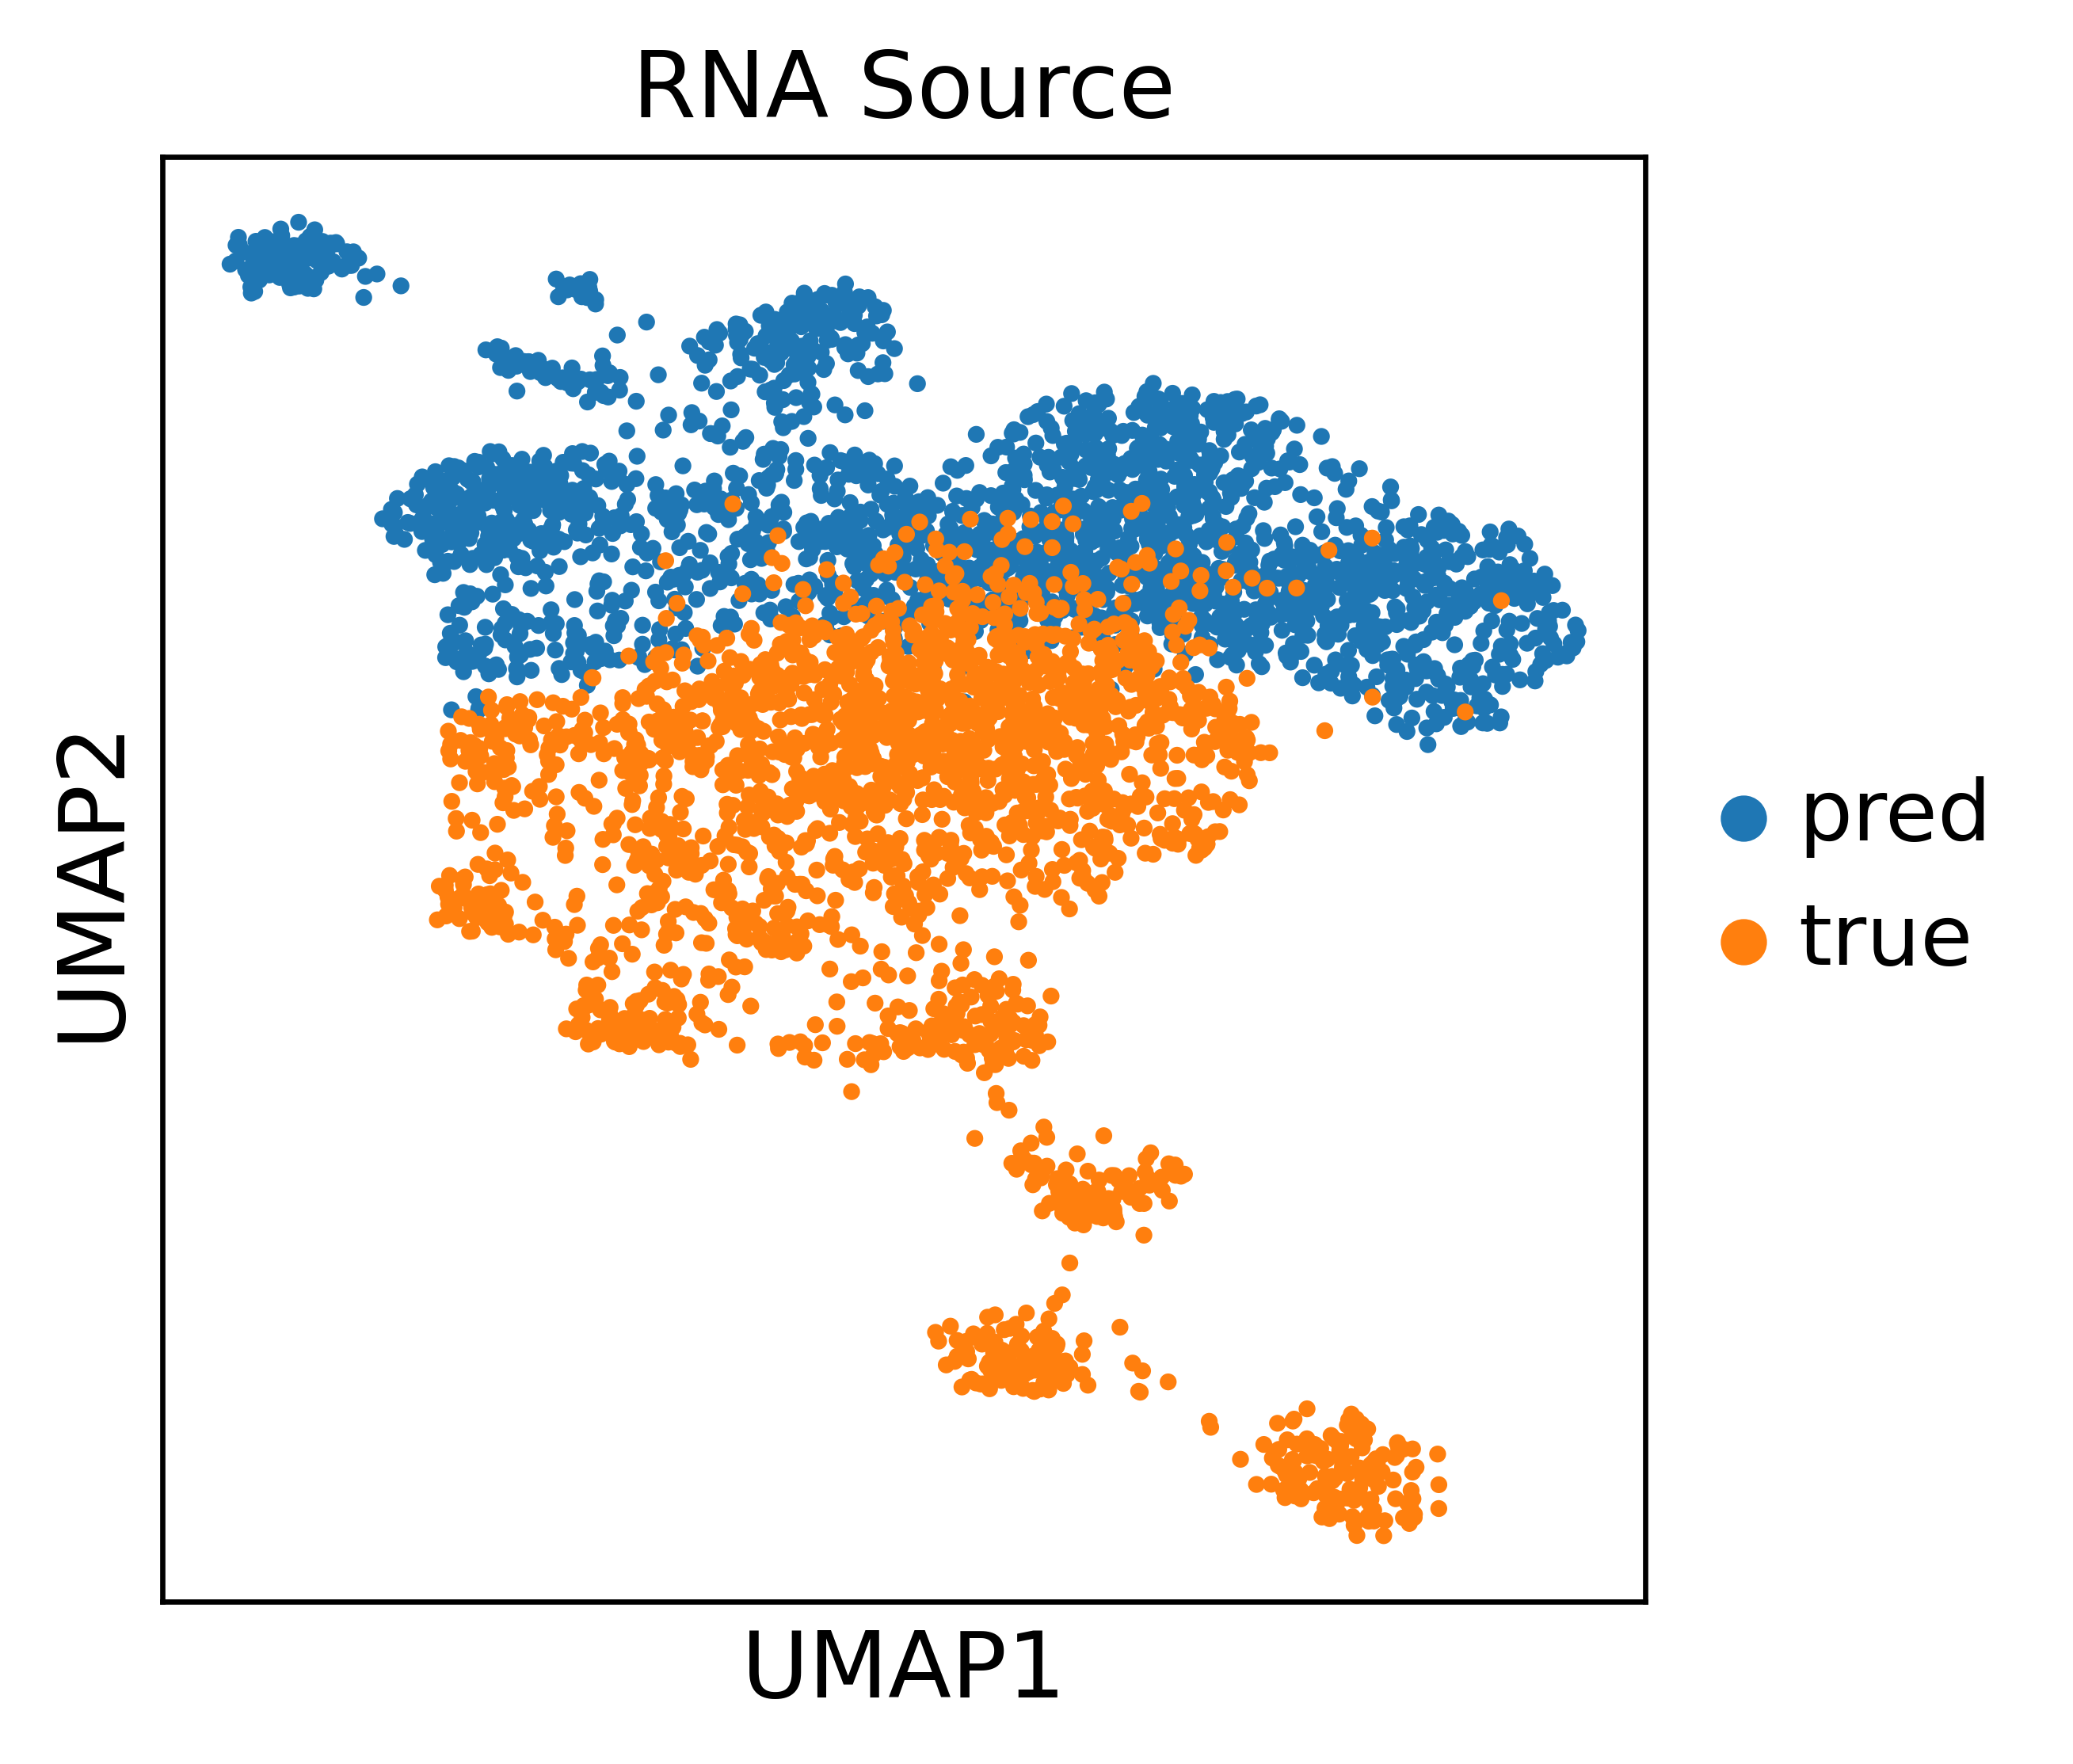

AnnData object with n_obs × n_vars = 4600 × 7445
    obs: 'RNA Source', 'leiden'
    uns: 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'umap', 'RNA Source_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [68]:
plot_umap(rna_concat, source_labels, label_name="RNA Source")